# 3DXRD indexing notebook - Friedel pair method  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

dset_path = ''

phase_str = 'Fe'

# path to parameters .json/.par
parfile = ''

# peak filtration options
cf_strong_frac = 0.991
cf_strong_dsmax = 1.01
cf_strong_dstol = 0.01

# friedel pair search options
womega = 1.0
weta = 1.0
wtth = 1.5
wI = 0.5

# indexing options
indexer_ds_tol = 0.003

rings_for_gen = [1, 3]

# now we want to decide which rings to score our found orientations against
# generally we can just exclude dodgy rings (close to other phases, only a few peaks in etc)
rings_for_scoring = [0, 1, 2, 3]

# the sequence of hkl tolerances the indexer will iterate through
hkl_tols_seq = [0.01, 0.02]
# the sequence of minpks fractions the indexer will iterate through
fracs = [0.9, 0.6]

# the max number of UBIs we can find per pair of rings
max_grains = 1000

# makemap refinement options
symmetry = "cubic"

gridpars = {
        'DSTOL' : 0.004,
        'NUL' : True,
        'FITPOS' : True,
        'tolangle' : 0.25,
        'toldist' : 100.,
        'NTHREAD' : 1 ,
        'NPKS': 25
}

absolute_minpks = 25

dset_prefix = 'ff'

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [3]:
# Parameters
phase_str = "Fe"
parfile = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/pars/pars_tdxrd.json"
cf_strong_frac = 0.991
cf_strong_dsmax = 1.01
cf_strong_dstol = 0.01
womega = 1.0
weta = 1.0
wtth = 1.5
wI = 0.5
indexer_ds_tol = 0.003
rings_for_gen = [1, 3]
rings_for_scoring = [0, 1, 2, 3]
hkl_tols_seq = [0.01, 0.02]
fracs = [0.9, 0.6]
max_grains = 1000
symmetry = "cubic"
gridpars = {
    "DSTOL": 0.004,
    "NUL": True,
    "FITPOS": True,
    "tolangle": 0.25,
    "toldist": 100.0,
    "NTHREAD": 1,
    "NPKS": 25,
}
absolute_minpks = 25
PYTHONPATH = "../"
dset_path = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/PROCESSED_DATA/20250221_JADB/friedel/FeAu_0p5_tR/FeAu_0p5_tR_ff1/FeAu_0p5_tR_ff1_dataset.h5"


In [4]:
import os
import numpy as np
import scipy.spatial
from matplotlib import pyplot as plt

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
import ImageD11.refinegrains
import ImageD11.grid_index_parallel
from ImageD11.sinograms import dataset
from ImageD11.nbGui import nb_utils as utils
from ImageD11.peakselect import select_ring_peaks_by_intensity

%matplotlib widget

# Load data
## Dataset

In [5]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/RAW_DATA/"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/TDXRD/FeAu/PROCESSED_DATA/20250221_JADB/friedel"
sample = "FeAu_0p5_tR"
dset = "ff1"
shape = ( 1, 1440)
# scans 1 from 1.1 to 1.1


## Parameters
Specify the path to your parameter file

In [6]:
ds.parfile = parfile
ds.save()

## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [7]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229}

In [8]:
ucell = ds.phases.unitcells[phase_str]
print(ucell.lattice_parameters, ucell.spacegroup)

[ 2.8694  2.8694  2.8694 90.     90.     90.    ] 229


## Peaks

In [9]:
cf_3d = ds.get_cf_3d_from_disk()
ds.update_colfile_pars(cf_3d, phase_name=phase_str) 
cf_3d_path = 'cf_3d.flt'
cf_3d.writefile(cf_3d_path)

Reading your columnfile in hdf format


# Visualise data
### $d^{*}$ vs $\eta$

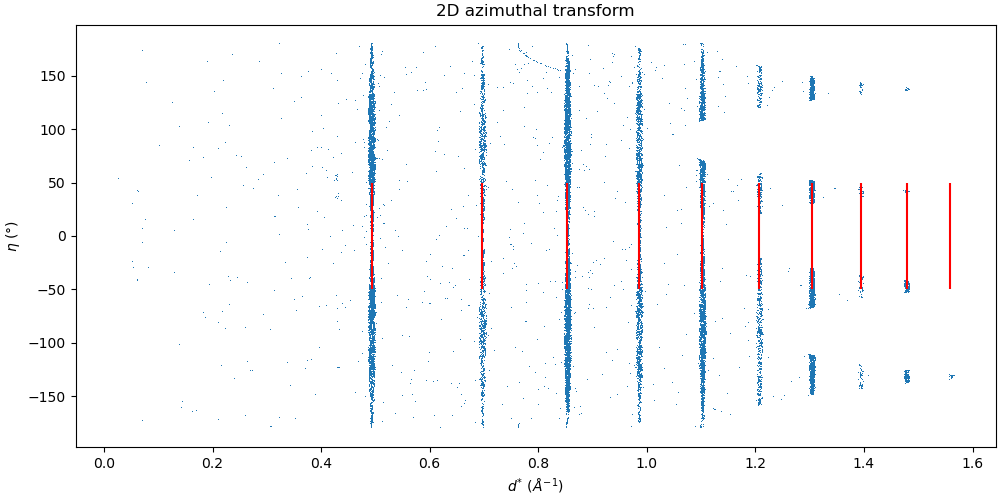

In [10]:
skip = 1  # we can skip peaks to speed up plotting if needed
ucell.makerings(cf_3d.ds.max())
fig, ax = plt.subplots(figsize=(10,5), layout='constrained')
ax.plot(cf_3d.ds[::skip], cf_3d.eta[::skip], ',')
ax.vlines(ucell.ringds, -50, 50, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', title='2D azimuthal transform')
plt.show()

# Filtration
Here we are filtering our peaks (`cf_3d`) to select only the strongest ones for indexing purposes only!  
We first filter the peaks in $d^{*}$ to keep only those close to the predicted peaks from the unit cell.  
We then sort our peaks by intensity, and take a certain intensity-weighted fraction of them.  
`dstol`: The tolerance in $d^{*}$ between a peak and a predicted reflection.  
`dsmax`: The maximum allowed peak $d^{*}$ value. Used to limit the number of rings given to the indexer - 6-8 rings max are normally sufficient.   
`frac`: The intensity fraction: `frac=0.9` keeps 90% of the peak intensity. We recommend that you choose a value close to the 'elbow' of the plot.

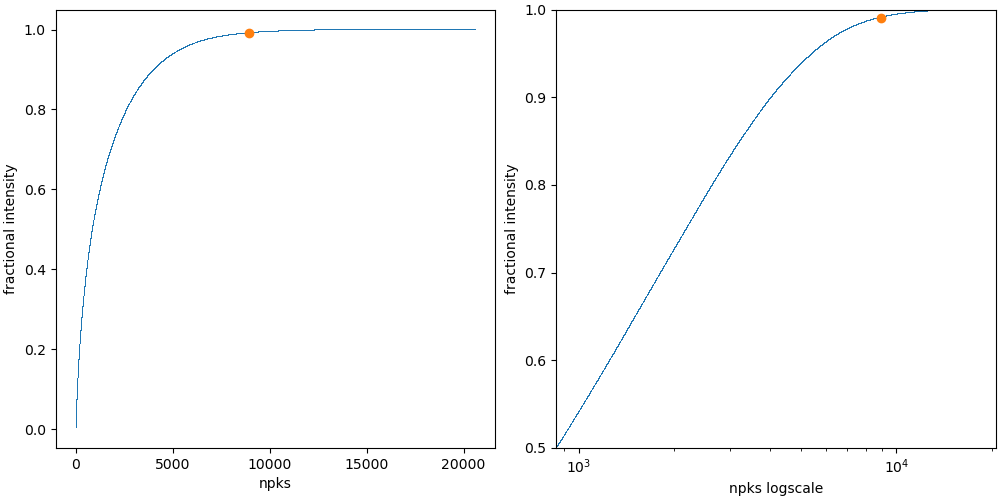

Filtered 8933 peaks from 31682


In [11]:
cf_strong = select_ring_peaks_by_intensity(cf_3d, frac=cf_strong_frac, dsmax=cf_strong_dsmax, dstol=cf_strong_dstol, ucell=ucell, doplot=0.5)

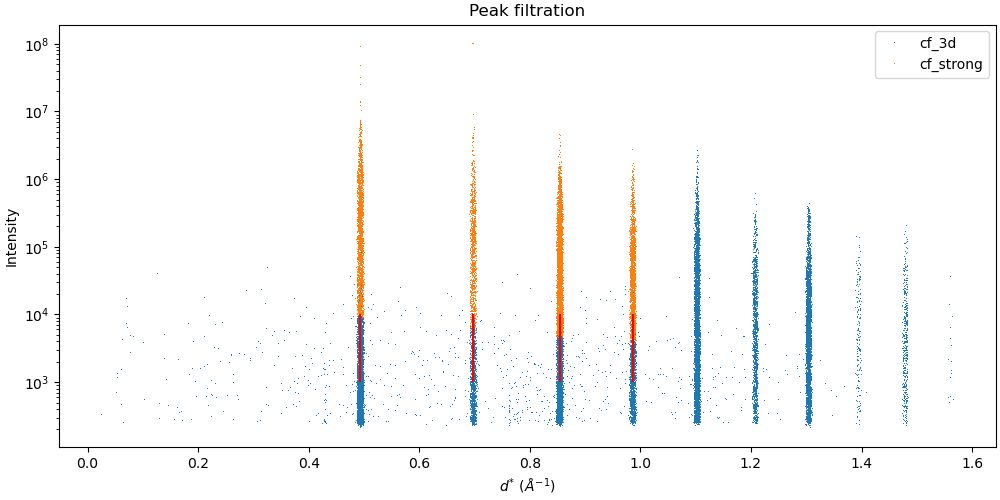

In [12]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_3d.ds[::skip], cf_3d.sum_intensity[::skip],',', label='cf_3d')
ax.plot(cf_strong.ds[::skip], cf_strong.sum_intensity[::skip],',', label='cf_strong')
ax.vlines(ucell.ringds, 1e3, 1e4, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend()
plt.show()

### Look for Friedel pairs

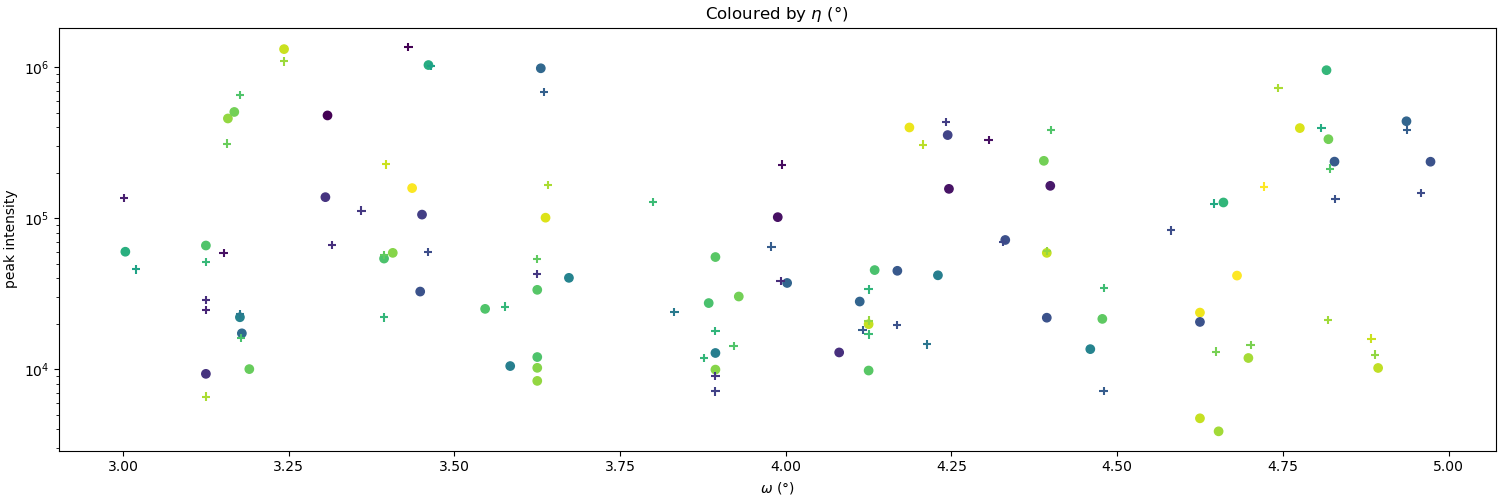

In [13]:
# compute Lorenz factor
lf = ImageD11.refinegrains.lf(cf_strong.tth, cf_strong.eta)

f = plt.figure(figsize=(15,5), layout='constrained')
ax = f.add_subplot()

# select peaks between 3 and 5 degrees in omega
om1 = (cf_strong.omega < 5) & (cf_strong.omega > 3)

# plot omega against intensity for those peaks, coloured by eta (azimuthal position on the ring)
ax.scatter(cf_strong.omega[om1], cf_strong.sum_intensity[om1], c=cf_strong.eta[om1], marker='o')

# the friedel pair of these peaks should be 180 degrees away in eta
etapair = 180 - cf_strong.eta

# modulate
etapair = np.where(etapair > 180, etapair - 360, etapair)

# select peaks for the friedel pairs between 183 and 185 degrees
om2 = (cf_strong.omega < 185) & (cf_strong.omega > 183)

# plot omega against intensity for the friedel pairs as crosses
ax.scatter(cf_strong.omega[om2] - 180, cf_strong.sum_intensity[om2], c=etapair[om2], marker='+')
ax.semilogy()

ax.set(xlabel=r'$\omega~(\degree)$', ylabel='peak intensity', title=r'Coloured by $\eta~(\degree)$')

# for valid friedel pairs, we should see 'o' and '+' markers close together in omega and intensity, with similar colours (eta)
plt.show()

In [14]:
def calc_tth_eta( c, pi, pj ):
    dX = c.xl[pi] + c.xl[pj]
    dY = c.yl[pi] + c.yl[pj]
    dZ = c.zl[pi] - c.zl[pj]
    r = np.sqrt(dY*dY + dZ*dZ)
    tth = np.degrees( np.arctan2( r, dX )  )
    eta = np.degrees(np.arctan2( -dY, dZ ))
    return tth, eta

def find_friedel_pairs(cf_in, womega=1.5, weta=0.2, wtth=1.5, wI=0.5, doplot=False):
    # create a 4-dimensional tree
    # dimensions are omega, eta, tth, intensity
    t1 = scipy.spatial.cKDTree( np.transpose( [ 
                                womega*(cf_in.omega%360),
                                weta*(cf_in.eta%360),
                                wtth*cf_in.tth,
                                wI*np.log10(cf_in.sum_intensity) ] ))
    
    # create another tree for the friedel pair side (omega + 180, 180 - eta)
    t2 = scipy.spatial.cKDTree( np.transpose([ 
                                 womega*((cf_in.omega+180)%360),
                                 weta*((180-cf_in.eta)%360),
                                 wtth* cf_in.tth,
                                 wI*np.log10(cf_in.sum_intensity) ] ))
    
    # create a distance matrix between trees with a max distance of 1, returning a sparse matrix
    coo = t1.sparse_distance_matrix( t2, max_distance=1, output_type='coo_matrix' ) # 1 degree eta might be tight?
    
    inds = np.arange(cf_in.nrows)
    
    # mask for peaks on one side of the friedel pair
    p1 = inds[coo.row]
    # mask for peaks on the other side of the friedel pair
    p2 = inds[coo.col]
    
    # compute tth-eta of friedel pairs
    tth, eta = calc_tth_eta( cf_in, p1, p2 )
    # mask for intensity for friedel pairs
    s1 = cf_3d.sum_intensity[p1]
    s2 = cf_3d.sum_intensity[p2]
    
    # convert tth to dstar
    dstar = 2*np.sin(np.radians(tth)/2)/cf_in.parameters.get('wavelength')
    
    if doplot:
        f,a = plt.subplots(2,1,figsize=(20,6), layout='constrained', sharex=True)
        a[0].hist2d(dstar,eta,bins=(2000,360), norm='log', weights=s1+s2)
        a[0].plot(ucell.ringds, np.zeros_like(ucell.ringds),"|r",lw=1,ms=90)
        a[0].set(ylabel=r'$\eta~(\degree)$')
        a[1].hist2d(dstar,coo.data,  # sum of squares of distance matrix
        #            np.log(s1+s2),
                    bins=(1000,128), norm='log');
        a[1].vlines(ucell.ringds, -50, 50, color='red')
        a[1].set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='distance for search')
        f.suptitle(r'Top: $d^{*}~(\AA^{-1})$ vs $\eta~(\degree)$ of Friedel pairs \n Bottom: $d^{*}~(\AA^{-1})$ vs 4D tree distance')
        plt.show()
    
    if doplot:
        f,a = plt.subplots(t1.data.shape[1],1,figsize=(20,6), layout='constrained', sharex=True)
        for i in range(t1.data.shape[1]):
            a[i].hist2d(dstar, t1.data[coo.row,i] - t2.data[coo.col,i], bins=(1000,128), norm='log')
            a[i].vlines(ucell.ringds, -0.1, 0.1, color='red')
            a[i].set(ylabel=[r'$\omega~(\degree)$', r'$\eta~(\degree)$', r'$2\theta~(\degree)$', 'Log peak intensity'][i])
        f.suptitle(r'$d^{*}~(\AA^{-1})$ vs error in [$\omega~(\degree)$, $\eta~(\degree)$, $2\theta~(\degree)$, intensity] for the friedel pair')
        f.supxlabel(r'$d^{*}~(\AA^{-1})$')
        plt.show()
    
    # Mask to powder rings
    m = np.zeros_like(p1, dtype=bool)
    for d in ucell.ringds:
        m |= abs(dstar - d)<0.002
    
    # make columnfiles for each side of the friedel pair
    c1 = cf_in.copyrows( p1[m] )
    c2 = cf_in.copyrows( p2[m] )
    
    c1.tth[:] = tth[m]
    c2.tth[:] = tth[m]
    c1.ds[:] = dstar[m]
    c2.ds[:] = dstar[m]
    
    if doplot:
        fig, ax = plt.subplots(layout='constrained')
        ax.plot(c1.eta%360, eta[m]%360,',')
        ax.set(xlabel=r'$\eta~(\degree)$', ylabel=r'$\eta~(\degree)$', title=r'Observed vs computed $\eta~(\degree)$ for Friedel pairs (c1)')
        plt.show()
    
    # computed eta values (variable eta) matches c1, so we take c1.eta as eta, then recompute c2.eta
    c1.eta[:] = eta[m]
    e2 = 180 - eta[m]
    c2.eta[:] = np.where( e2 > 180, e2-360, e2)
    
    # combine paired peaks into one columnfile
    cpair = ImageD11.columnfile.colfile_from_dict({
        t: np.concatenate( (c1[t], c2[t]) ) for t in c1.titles } )
    cpair.parameters = cf_in.parameters
    
    if doplot:
        fig, ax = plt.subplots(figsize=(20,6), layout='constrained')
        ax.plot(c1.ds, c1.eta, ',')
        ax.plot(c2.ds, c2.eta, ',')
        ax.plot(cpair.ds, cpair.eta, ',')
        ax.vlines(ucell.ringds, -50, 50, color='red')
        ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$')
        plt.show()
    
    cpair.gx[:],cpair.gy[:],cpair.gz[:] = ImageD11.transform.compute_g_vectors( cpair.tth, cpair.eta, cpair.omega, cpair.parameters.get('wavelength') )
    
    if doplot:
        fig, ax = plt.subplots(figsize=(20,6), layout='constrained')
        ax.plot(cpair.ds, cpair.sum_intensity*np.exp(5*cpair.ds**2),',')
        ax.vlines(ucell.ringds, 1e3, 1e4, color='red')
        ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Weighted Sum intensity', yscale='log')
        plt.show()
        
    return cpair

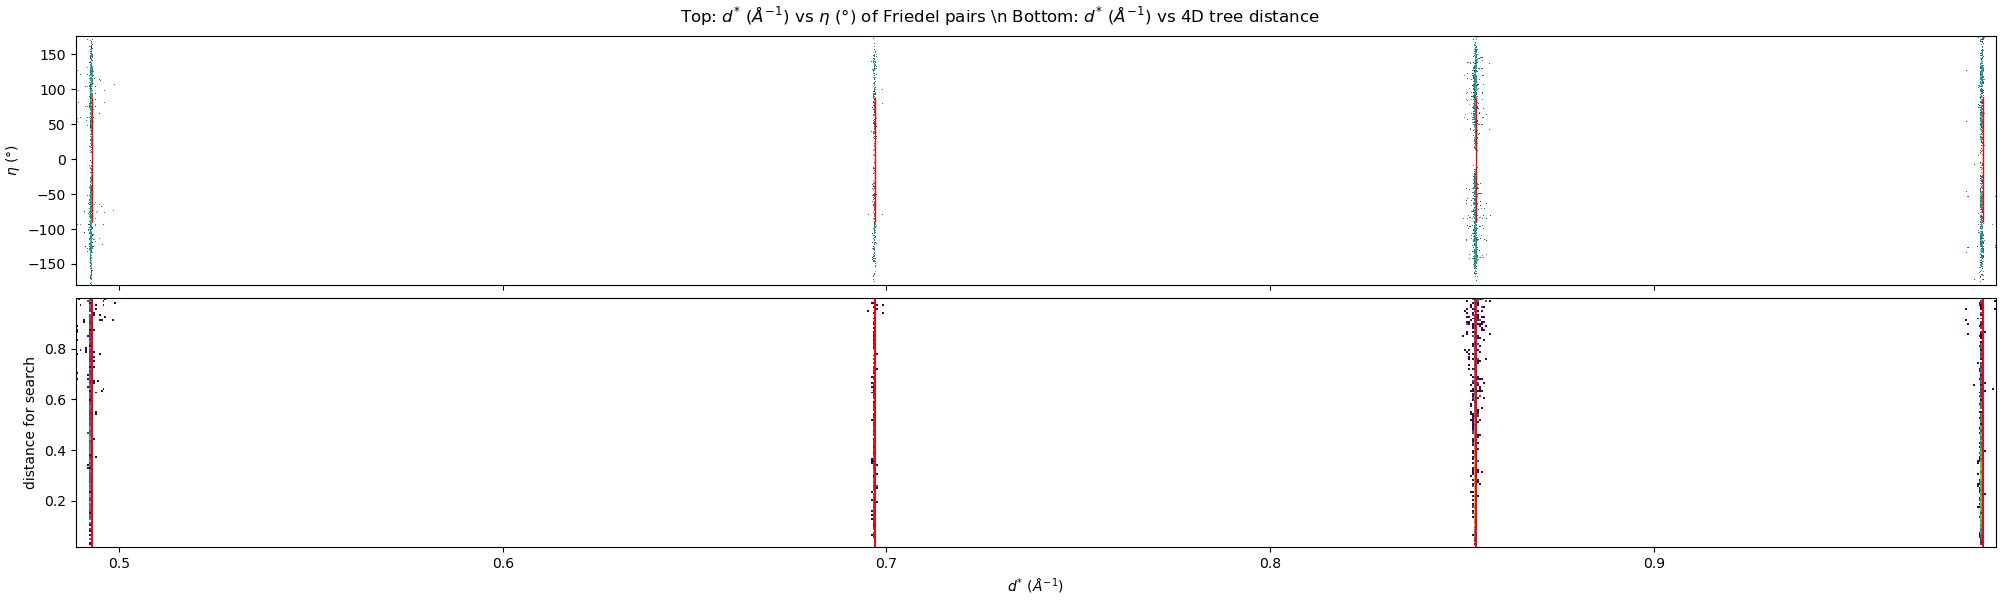

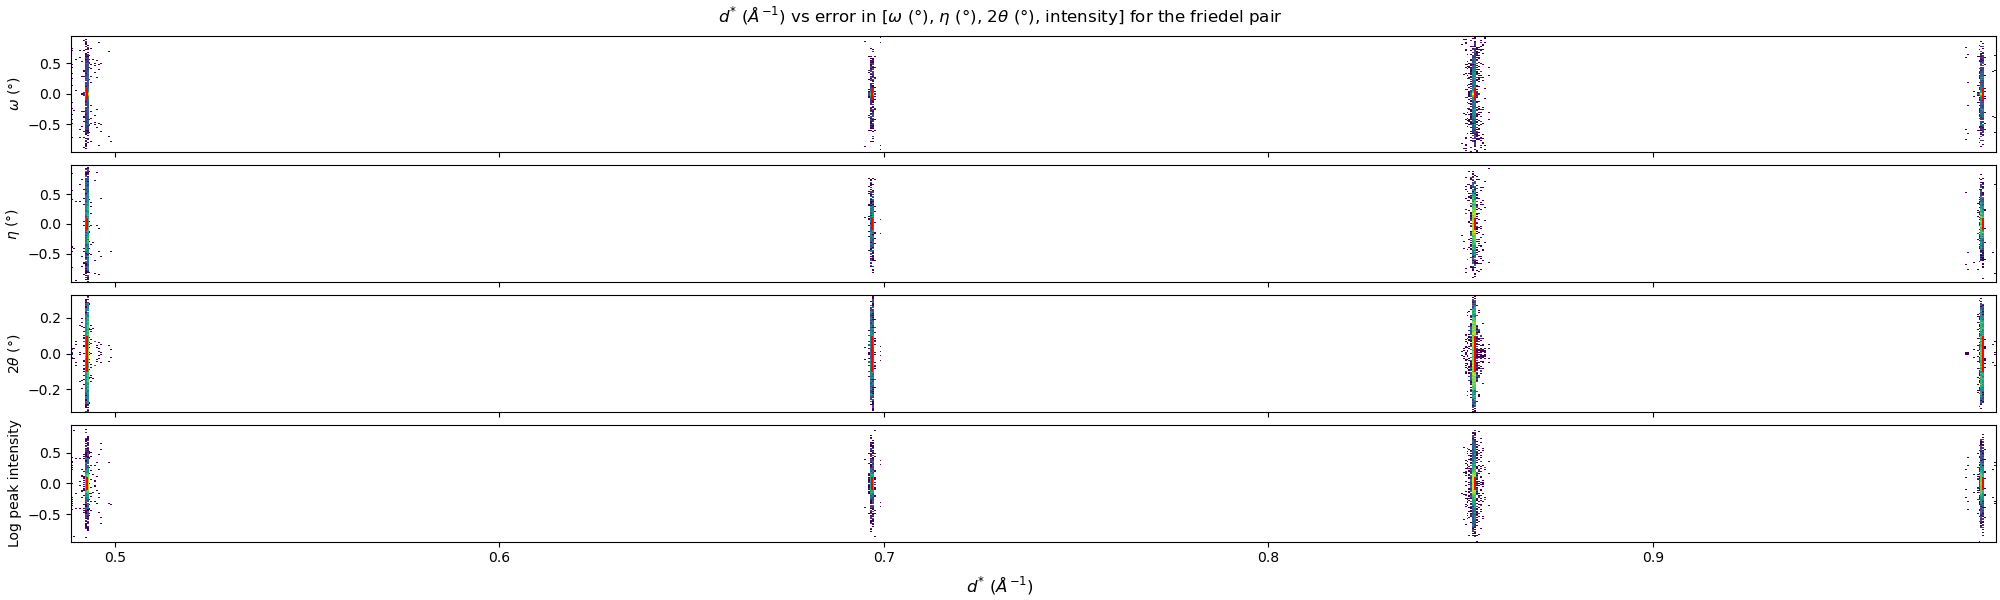

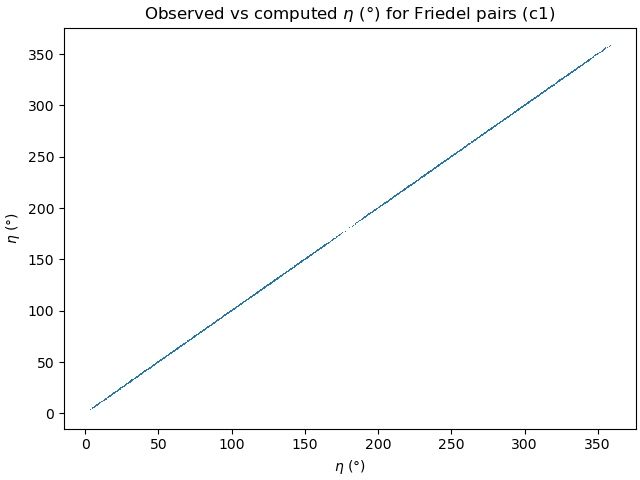

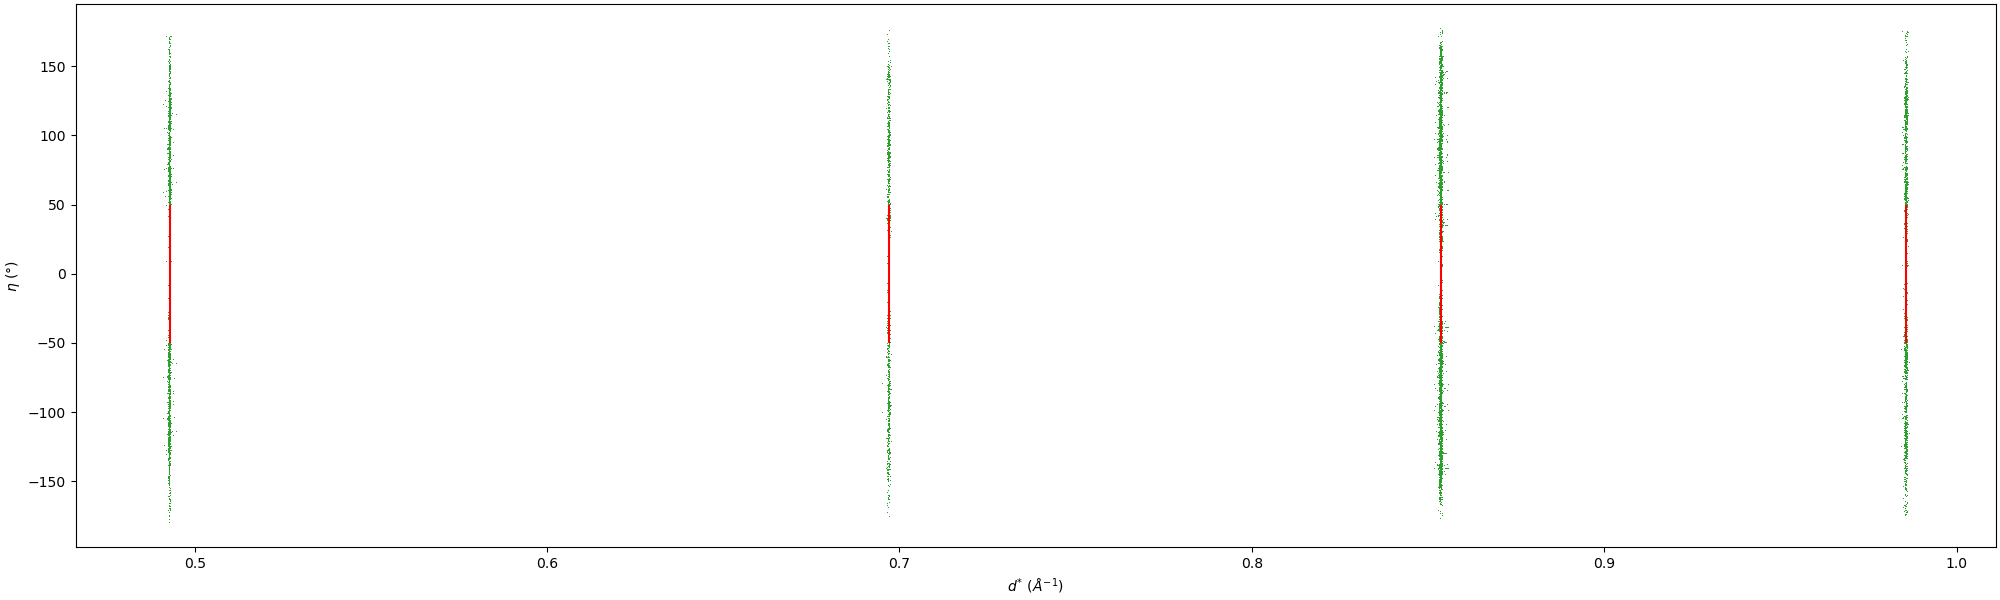

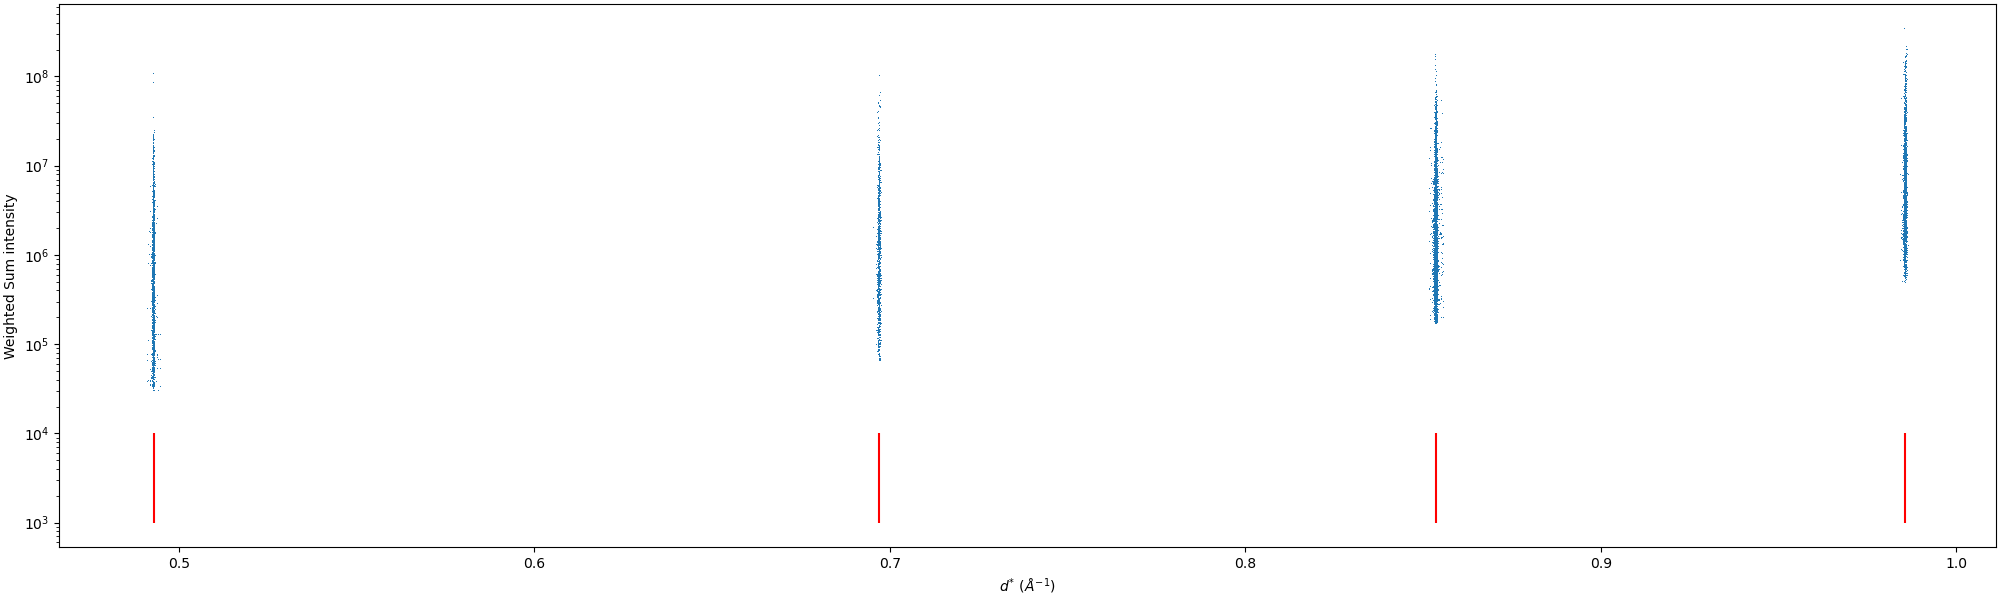

In [15]:
cf_friedel_pairs = find_friedel_pairs(cf_strong, womega=womega, weta=weta, wtth=wtth, wI=wI, doplot=True)

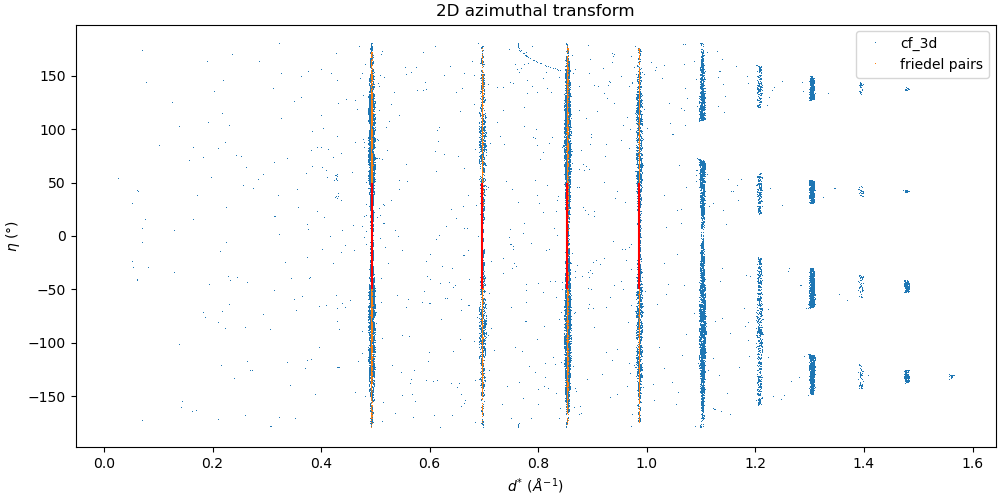

In [16]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_3d.ds[::skip], cf_3d.eta[::skip],',', label='cf_3d')
ax.plot(cf_friedel_pairs.ds[::skip], cf_friedel_pairs.eta[::skip],',', label='friedel pairs')
ax.vlines(ucell.ringds, -50, 50, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', title='2D azimuthal transform')
ax.legend()
plt.show()

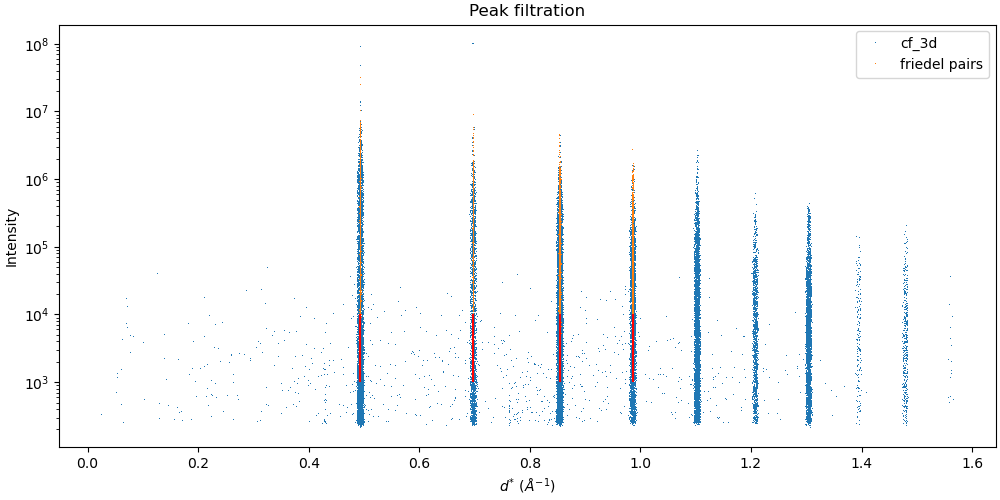

In [17]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_3d.ds[::skip], cf_3d.sum_intensity[::skip],',', label='cf_3d')
ax.plot(cf_friedel_pairs.ds[::skip], cf_friedel_pairs.sum_intensity[::skip],',', label='friedel pairs')
ax.vlines(ucell.ringds, 1e3, 1e4, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend()
plt.show()

# Indexing
Now we index the Friedel pair peaks

In [18]:
cosine_tol = np.cos(np.radians(90 - ds.ostep))
_, indexer = utils.do_index(cf=cf_friedel_pairs,
                            dstol=indexer_ds_tol,
                            forgen=rings_for_gen,
                            foridx=rings_for_scoring,
                            hkl_tols=hkl_tols_seq,
                            fracs=fracs,
                            cosine_tol=cosine_tol,
                            max_grains=max_grains,
                            unitcell=ucell
)

info: Indexing 22430 peaks
108 peaks expected
Trying these rings (counts, multiplicity, ring number): [(2324, 6, 1), (4652, 12, 3)]


0.9 0.01 72


0.9 0.02 74


0.6 0.01 76


0.6 0.02 77


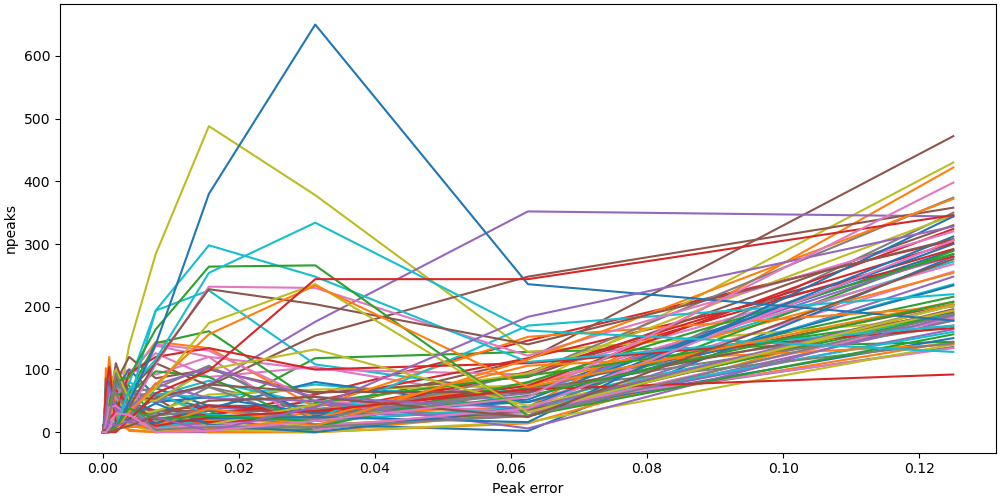

In [19]:
indexer.histogram_drlv_fit()
fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))
for row in indexer.histogram:
    ax.plot(indexer.bins[1:-1], row[:-1],'-')
ax.set(xlabel='Peak error', ylabel='npeaks')
plt.show()

# Grain refinement

In [20]:
nproc = len(os.sched_getaffinity(os.getpid())) - 3
omega_slop = ds.ostep/2
gridpars['TOLSEQ'] = [hkl_tols_seq[0],]
gridpars['COSTOL'] = np.cos(np.radians(90 - ds.ostep))
gridpars['NPROC'] = nproc
gridpars['OMEGAFLOAT'] = omega_slop
gridpars['SYMMETRY'] = symmetry
gridpars['RING1'] = rings_for_gen
gridpars['RING2'] = rings_for_gen
cf_indexed = indexer.colfile.copy()
cf_indexed.addcolumn(indexer.ga.copy(), 'labels')
cf_indexed.addcolumn(np.zeros(cf_indexed.nrows), 'drlv2')
for v in 'xyz':
    cf_3d.parameters.stepsizes[f't_{v}'] = 0.1
fittedgrains = []
for i in range(len(indexer.ubis)):
    grains = [ImageD11.grain.grain(indexer.ubis[i].copy() ),]
    # only take indexed spots using Friedel pairs
    cfit = ImageD11.columnfile.colfile_from_dict(
        { t:cf_indexed[t][indexer.ga==i+1] for t in cf_indexed.titles} )
    if cfit.nrows == 0:
        continue
    fitted = ImageD11.grid_index_parallel.domap( cf_3d.parameters,
                                    cfit,
                                    grains,
                                    gridpars )
    if len(fitted) > 0:
        fittedgrains.append( fitted[0] )

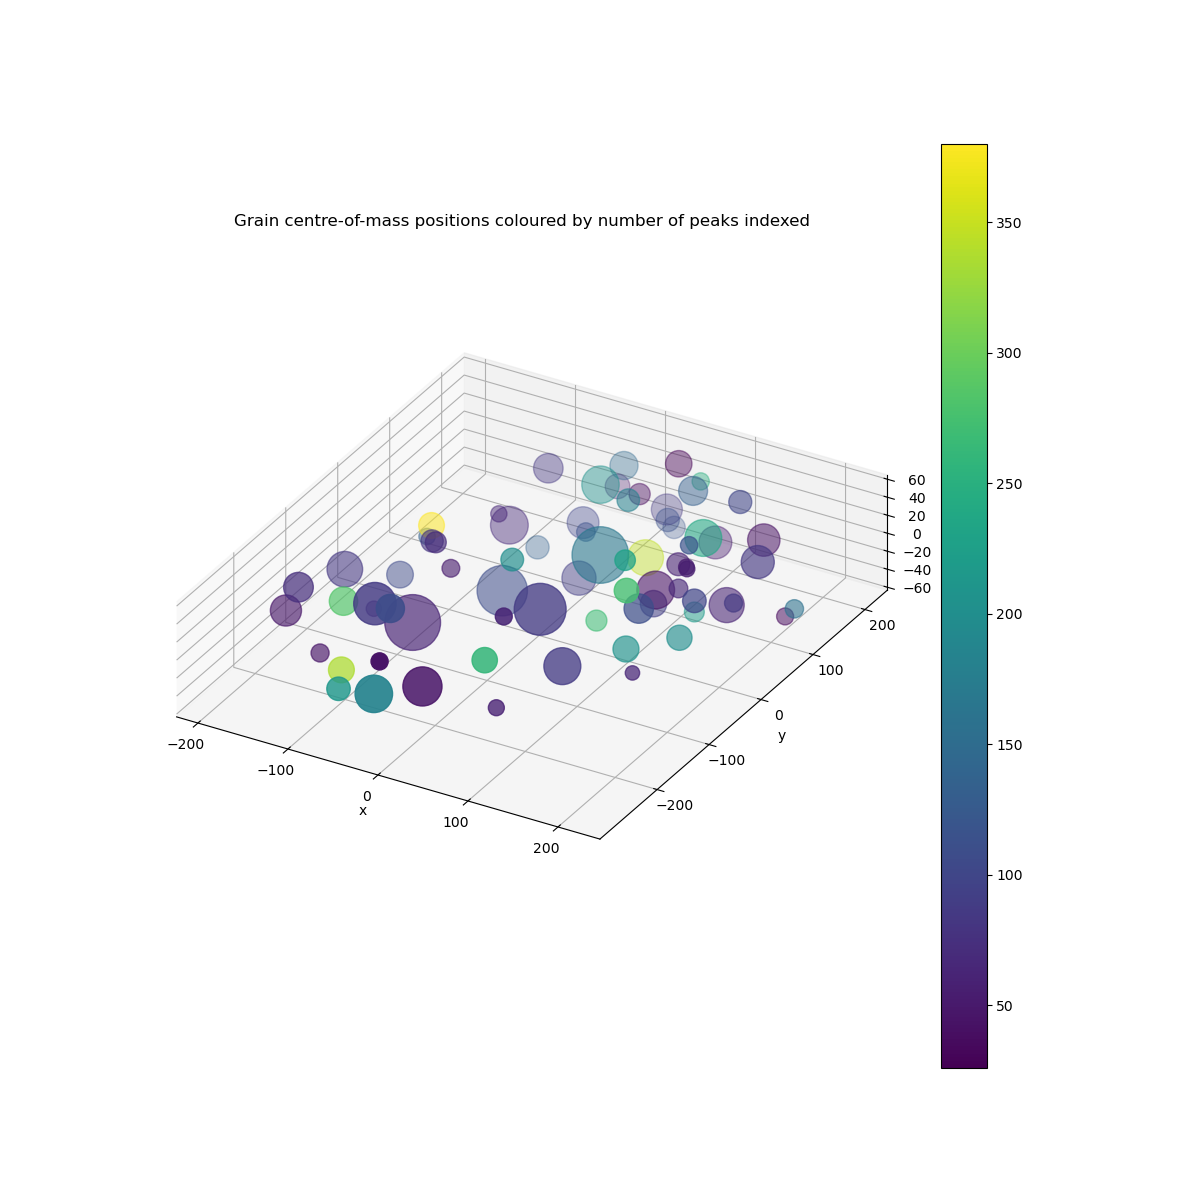

In [21]:
utils.plot_grain_positions(fittedgrains, colour='npks', centre_plot=False, size_scaling=0.5)

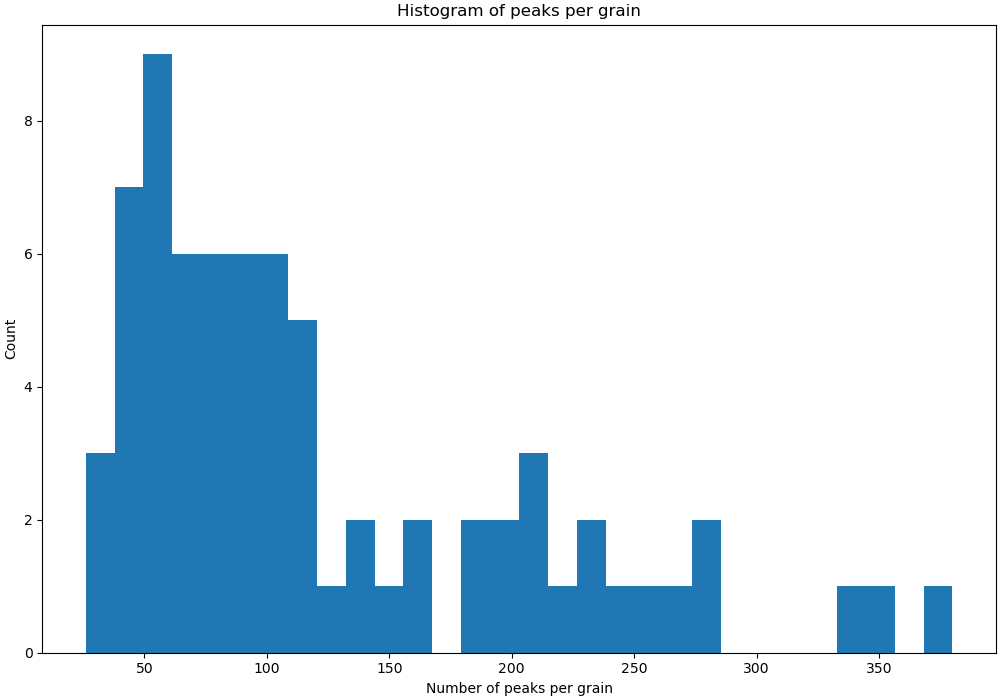

In [22]:
fig, ax = plt.subplots(figsize=(10, 7), layout='constrained')
ax.hist([float(grain.npks) for grain in fittedgrains], bins=30)
ax.set(xlabel='Number of peaks per grain', ylabel='Count', title='Histogram of peaks per grain')
plt.show()

In [23]:
# filter out grains with fewer than absolute_minpks peaks
# most grains should have a high number of peaks
# choose absolute_minpks such that the low-peak grains are removed
grains_filtered = [grain for grain in fittedgrains if float(grain.npks) > absolute_minpks]

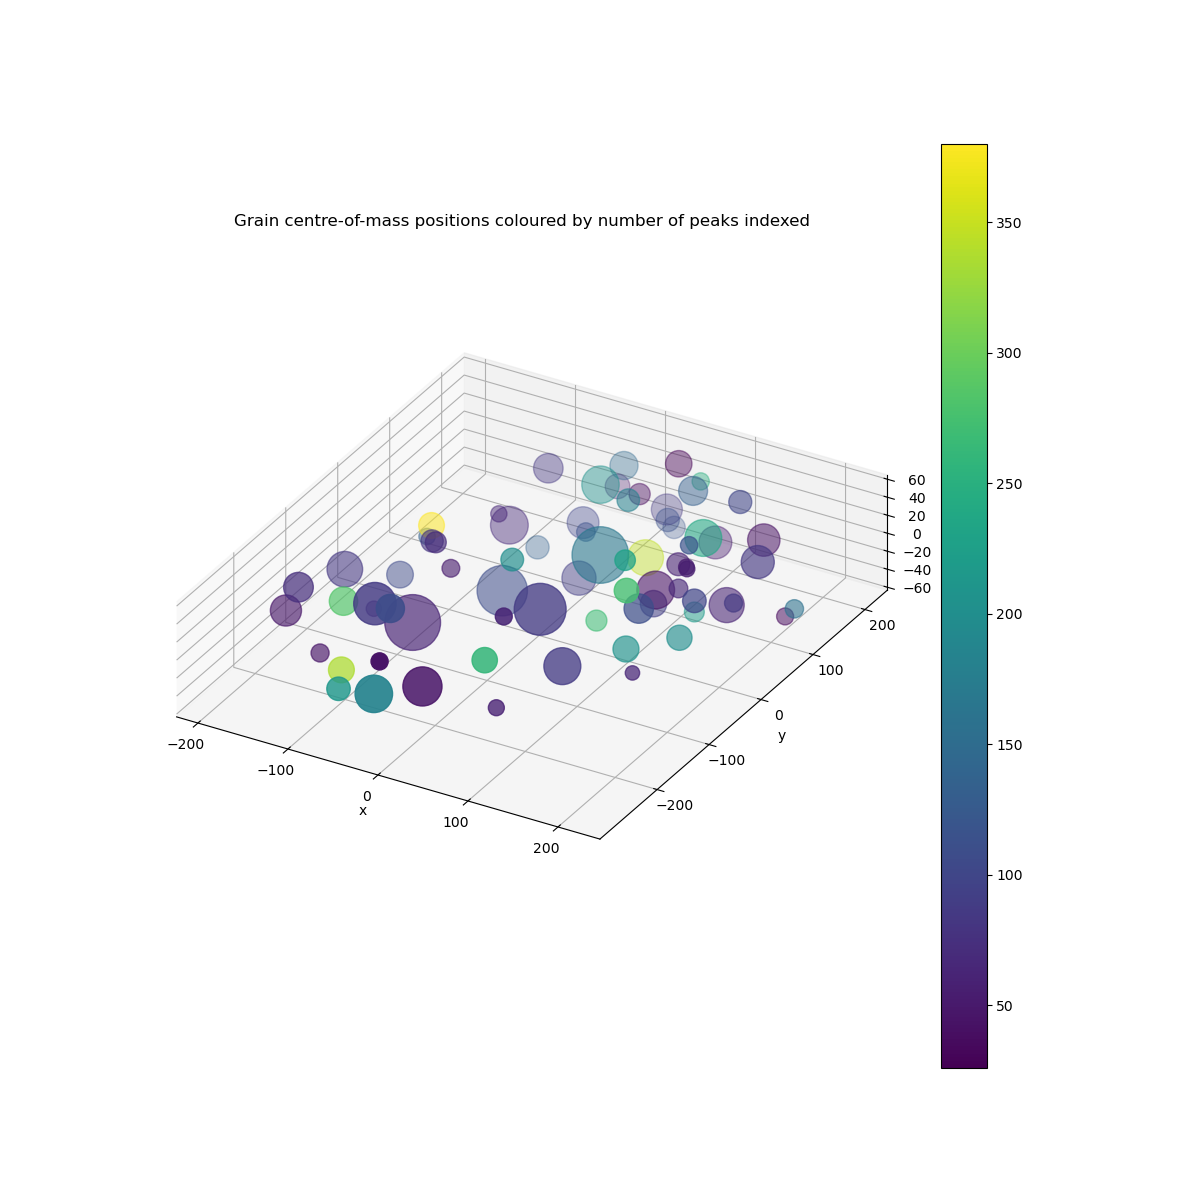

In [24]:
utils.plot_grain_positions(grains_filtered, colour='npks', centre_plot=False, size_scaling=0.5)

In [25]:
filtered_map_path = 'nice_grains.map'
ImageD11.grain.write_grain_file(filtered_map_path, grains_filtered)

In [26]:
# run makemap again against all peaks
new_filtered_map_path = 'nice_grains.map.new'
new_cf_3d_path = cf_3d_path + '.new'
final_makemap_tol = hkl_tols_seq[0]
oldparfile = phase_str + '.par'
ds.phases.to_old_pars_file(oldparfile, phase_str)
makemap_output = !makemap.py -p {oldparfile} -u {filtered_map_path} -U {new_filtered_map_path} -f {cf_3d_path} -s {symmetry} -t {final_makemap_tol} --omega_slop={omega_slop} --no_sort
grains_final = ImageD11.grain.read_grain_file(new_filtered_map_path)
cf_3d = ImageD11.columnfile.columnfile(new_cf_3d_path)

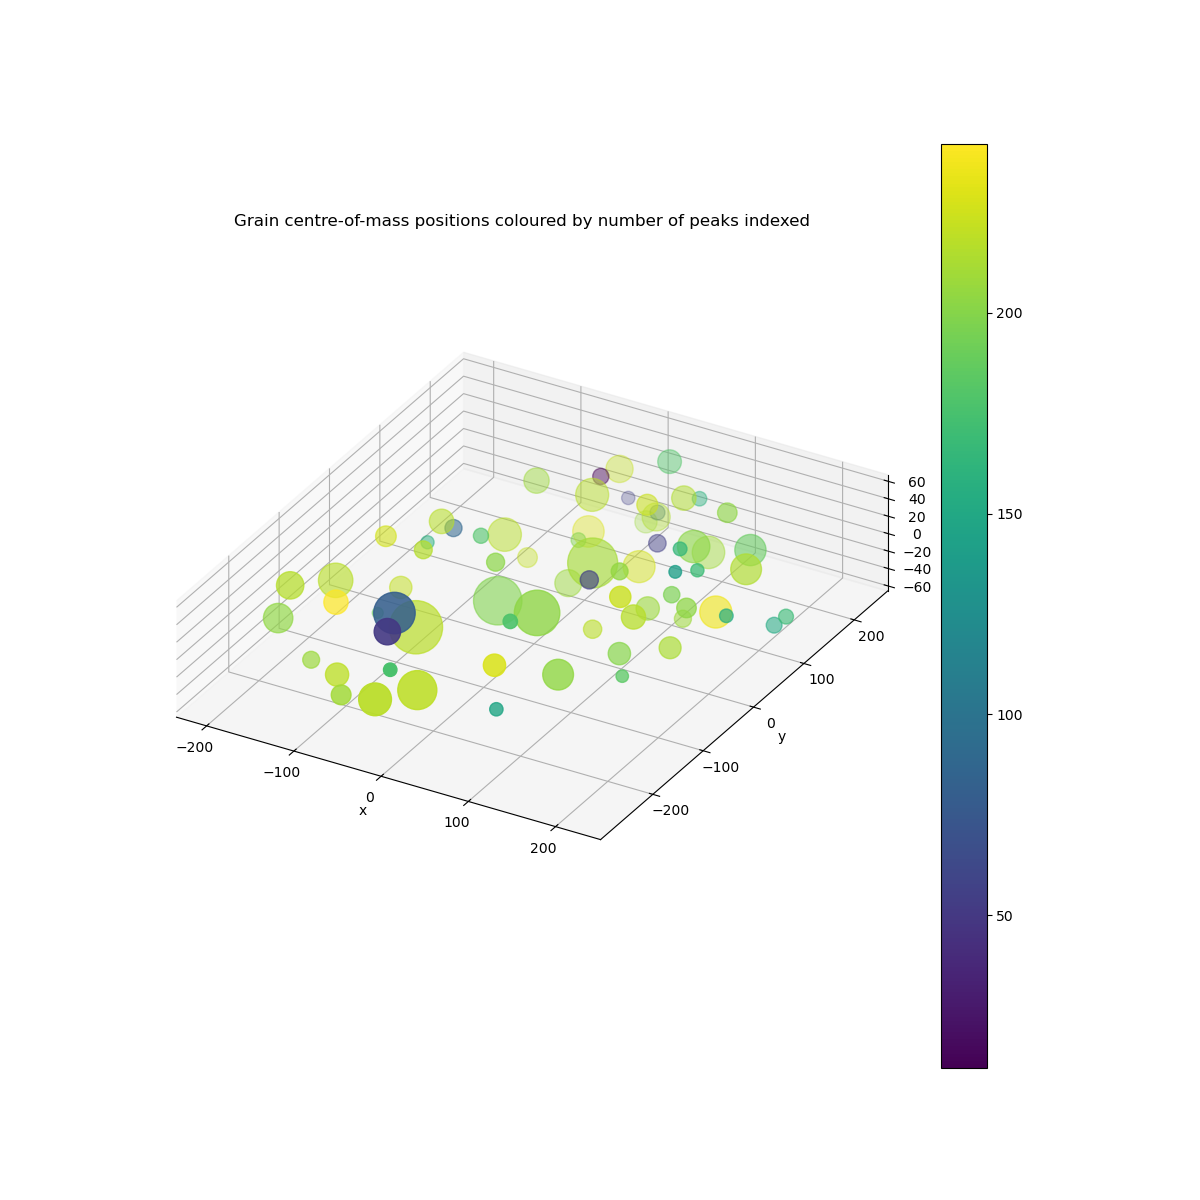

In [27]:
utils.plot_grain_positions(grains_final, colour='npks', centre_plot=False, size_scaling=0.5)

Using 0.12500652156180614 degree slop
resetting labels


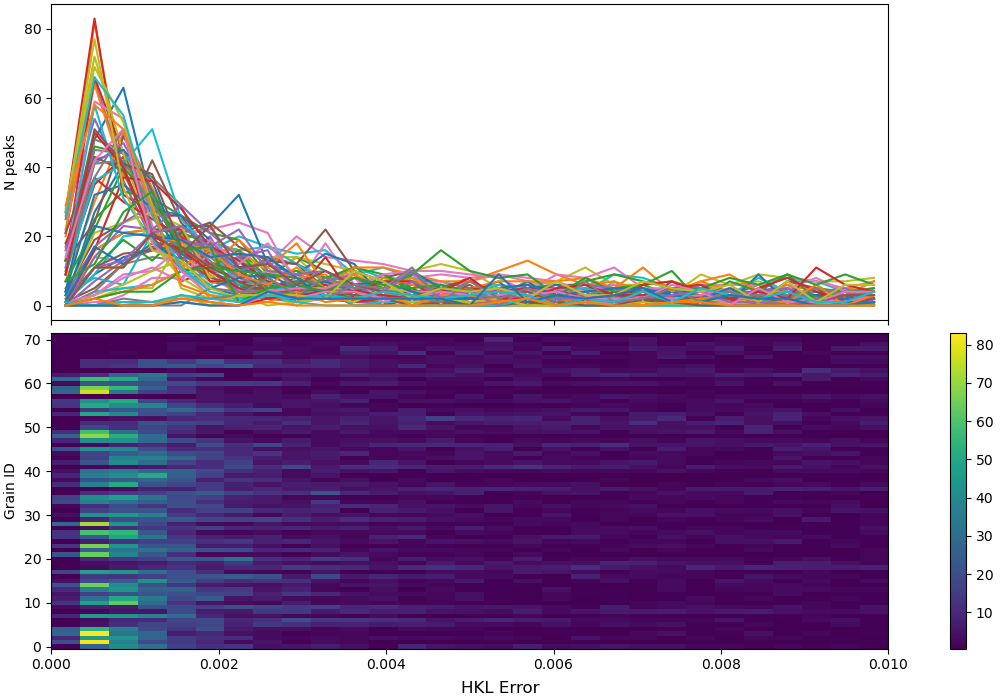

In [28]:
utils.plot_grain_histograms(new_cf_3d_path, new_filtered_map_path, oldparfile, omega_slop, tol=hkl_tols_seq[0])

Median unit cell: [ 2.86912825  2.86978665  2.87062071 89.99115123 90.00128393 90.01099236]


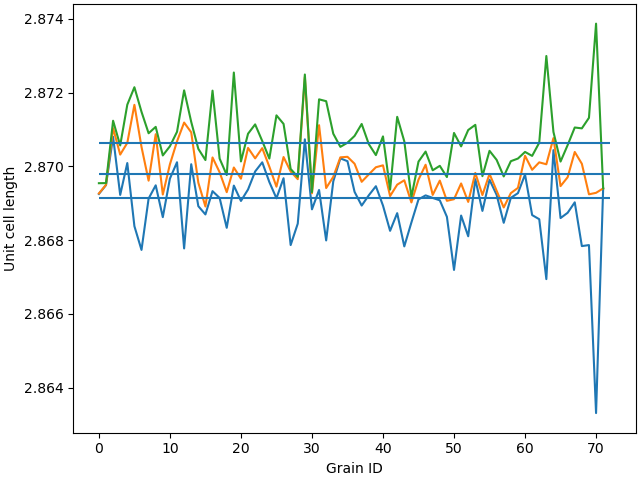

In [29]:
unit_cell_lengths = np.array([np.sort(g.unitcell.copy()) for g in grains_final])
median_unit_cell = np.median(unit_cell_lengths, axis=0)
print("Median unit cell:", median_unit_cell)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(unit_cell_lengths[:,:3])
ax.hlines(median_unit_cell[:3], 0, len(unit_cell_lengths))
ax.set(xlabel="Grain ID", ylabel="Unit cell length")
plt.show()

# Export Data

In [30]:
# write 3D columnfile to disk
ImageD11.columnfile.colfile_to_hdf(cf_3d, ds.col3dfile, name='peaks')
ds.save_grains_to_disk(grains_final, phase_name=phase_str)
ds.save()

# Deleting temporary files

In [31]:
for path in [
    cf_3d_path,
    filtered_map_path,
    new_filtered_map_path,
    new_cf_3d_path,
]:
    if os.path.exists(path):
        os.remove(path)